# Notes: 
    
Contextual bandit

Reward is yards gained + touchdown + first down

Arms will be the play types 

Context will be set of features

Will need some sort of randomization component to not exploit plays 

need to find best play for each context

Evaluate against replay

Find real time plays that match prediction 

See how many are successful 

Success is within sd of yards gained, touchdown, first down

In [1]:
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Download and prep Data

In [2]:
#download data
!aws s3 cp s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet NFL_PBP_Data_2010_2022_original.parquet

download: s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet to ./NFL_PBP_Data_2010_2022_original.parquet


In [3]:
#Load Data
df = pd.read_parquet('NFL_PBP_Data_2010_2022_original.parquet', engine='pyarrow')
df.head()
print(df.shape)

(588078, 384)


In [4]:
df = df[df['play_type'].isin(['pass', 'run', 'punt', 'extra_point', 'field_goal']) ]
df = df[~(df['game_half'] == 'Overtime' )]

In [5]:
def transform_off_personnel(row):

   rb_count = 0
   te_count = 0
   wr_count = 0
   ol_count = 0
   dl_count = 0
   db_count = 0

   if not pd.isna(row['offense_personnel']):
       personnel = row['offense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'RB':
               rb_count = int(p[0])
           elif p[2:4] == 'TE':
                te_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
               db_count = int(p[0])

   return pd.Series([rb_count,te_count,wr_count,ol_count,dl_count, db_count])

df[['off_rb_count','off_te_count','off_wr_count','off_ol_count','off_dl_count', 'off_db_count']] = df.apply(transform_off_personnel, axis=1)

In [6]:
def transform_def_personnel(row):

   dl_count = 0
   db_count = 0
   lb_count = 0
   rb_count = 0
   wr_count = 0
   ol_count = 0
   
   if not pd.isna(row['defense_personnel']):
       personnel = row['defense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'LB':
                lb_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
                db_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'RB':
                rb_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
                
   return pd.Series([dl_count,db_count,lb_count,rb_count,wr_count,ol_count])

df[['def_dl_count','def_db_count','def_lb_count','def_rb_count','def_wr_count','def_ol_count']] = df.apply(transform_def_personnel, axis=1)

In [7]:
def PlayType_normalized(s):
  if s['play_type_nfl'] == 'PASS': 
    return 'PASS'
  elif s['play_type_nfl'] == 'RUSH': 
    return 'RUSH'
  else:
    return 'OTHER'
df['PlayType_normalized'] = df.apply(PlayType_normalized, axis=1)

In [8]:
df = df[~(df['PlayType_normalized'] == 'OTHER' )]

In [9]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df['yardline_binned'] = pd.cut(df['yardline_100'], bins)

# Light EDA

In [10]:
print(df.shape)

(392032, 398)


(array([ 90673.,      0.,      0., 105245.,      0.,      0.,  91066.,
             0.,      0., 105048.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

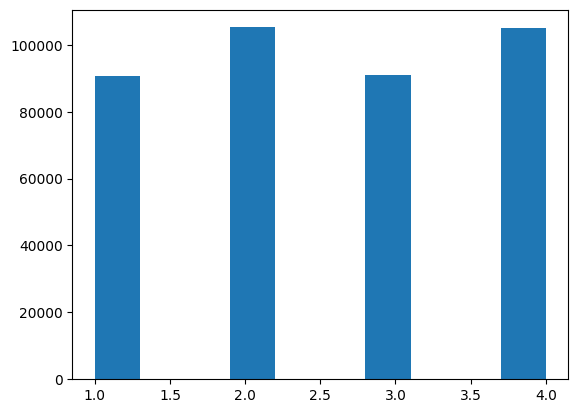

In [11]:
plt.hist(df[['qtr']])

(array([176069.,      0.,      0., 131372.,      0.,      0.,  78261.,
             0.,      0.,   6330.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

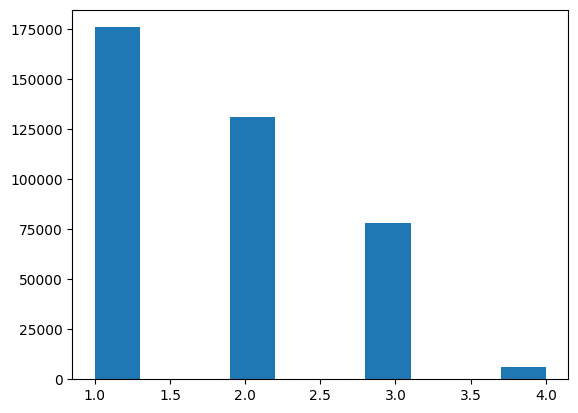

In [12]:
plt.hist(df[['down']])

(array([8.57220e+04, 2.65111e+05, 2.55280e+04, 1.22610e+04, 2.55800e+03,
        6.76000e+02, 1.45000e+02, 2.10000e+01, 7.00000e+00, 3.00000e+00]),
 array([ 1.        ,  5.9000001 , 10.80000019, 15.69999981, 20.60000038,
        25.5       , 30.39999962, 35.29999924, 40.20000076, 45.09999847,
        50.        ]),
 <BarContainer object of 10 artists>)

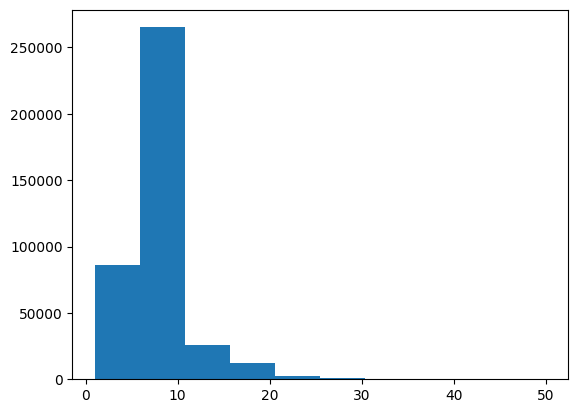

In [13]:
plt.hist(df[['ydstogo']])

In [14]:
context_qtr = df.qtr.unique()
context_down = df.down.unique()
context_yds = ['long', '10', '5', '1']
plays = ['PASS', 'RUSH'] 

print(context_qtr)
print(context_down)
print(context_yds)

[1. 2. 3. 4.]
[1. 2. 3. 4.]
['long', '10', '5', '1']


(array([265111.,      0.,      0.,  64463.,      0.,      0.,  41199.,
             0.,      0.,  21259.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

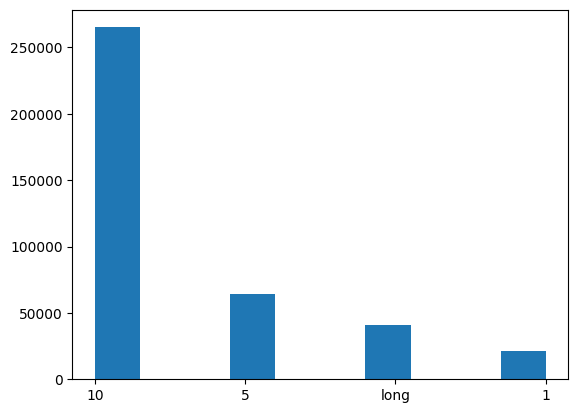

In [15]:
def ydstogo_binning(row): 
    if row.ydstogo > 10: 
        return 'long'
    elif row.ydstogo > 5: 
        return '10'
    elif row.ydstogo > 1: 
        return '5'
    else:
        return '1'




df['ydstogo_binned'] = df.apply(ydstogo_binning, axis=1)
plt.hist(df[['ydstogo_binned']])

# Create Bandit

In [34]:
class ContextualBandit: 
    def __init__(self, arms, e): 
        self.arms = arms
        self.e = e
        self.n = 0
        self.mean_reward = 0
        self.context_rewards = {}
        self.context_n = {}
        self.match_count = 0
        self.success_count = 0 
        
    
    def pull(self, context):
        '''
        Use a row in the dataframe to update average rewards given context
        '''
        
        #Current rewards for context
        curr_context_rewards = self.context_rewards[context]
        
        #decide to use highest reward or try something new
        p = np.random.rand()
        if p < self.e: 
            selected_arm_idx = random.randint(0, len(self.arms) - 1)
        else: 
            selected_arm_idx = np.argmax(curr_context_rewards)
        
        #Get reward for decision
        reward = self.get_reward(self.arms[selected_arm_idx], context)

        #Update counts
        self.n += 1
        self.context_n[context][selected_arm_idx] += 1
        
        #Update average rewards
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        curr_context_rewards[selected_arm_idx] = curr_context_rewards[selected_arm_idx] + (reward - curr_context_rewards[selected_arm_idx]) / self.context_n[context][selected_arm_idx]
    
    def get_reward(self, arm, context):
        '''
        Find expected reward for chosen arm in context
        TODO: Replace with actual prediction models
        '''
        yds_gained = np.random.normal()
        touchdown_pct = np.random.normal()
        first_down_pct = np.random.normal()
        
        return yds_gained + touchdown_pct + first_down_pct
    
    def train(self, df): 
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 
            
            #Pull context
            context_key = str(row['qtr']) + "_" + str(row['down']) + "_" + str(row['ydstogo_binned'])
            
            #Initialize rewards if this is new context
            if context_key not in self.context_rewards.keys(): 
                self.context_rewards[context_key] = np.zeros(len(self.arms))
                self.context_n[context_key] = np.zeros(len(self.arms))
            
            #Update rewards
            self.pull(context_key)

    def predict(self, df): 
        '''
        Predict play for each context based on max reward
        '''
        predictions = []
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 

            #Pull context
            context_key = str(row['qtr']) + "_" + str(row['down']) + "_" + str(row['ydstogo_binned'])
            
            #Pull relevant rewards vector
            rewards = self.context_rewards[context_key]
            #find highest rewards
            max_idx = np.argmax(rewards)
            #Select associated arm with highest rewards
            arm = self.arms[max_idx] 
            #Add to predictions
            predictions.append(arm)
            
            if row.PlayType_normalized == arm:
                self.match_count += 1
                if row.success: 
                    self.success_count += 1
 
        return predictions

    def get_evaluation_metrics(self):
        return self.match_count, self.success_count, self.success_count / self.match_count
    

In [39]:
# bandit = ContextualBandit(['PASS', 'RUSH'], 0.1)

In [40]:
# df_small = df.sample(10)
# display(df_small)

In [41]:
# bandit.train(df_small)

In [42]:
# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)

In [49]:
def define_successful_play(row): 
    if row.yards_gained > 3 or row.touchdown or row.first_down:
        return 1
    else:
        return 0
    
df['success'] = df.apply(define_successful_play, axis=1)

In [50]:
train_df, test_df = train_test_split(df, test_size=.20)

In [51]:
bandit = ContextualBandit(['PASS', 'RUSH'], 0.1)
bandit.train(train_df)

# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)
# print("==========")
print(bandit.mean_reward)

0.003251307565911111


In [52]:
predictions = bandit.predict(test_df)

In [53]:
print(bandit.get_evaluation_metrics())

(40900, 17957, 0.43904645476772614)


# Next Steps

* Evaluation of bandit
* Move context pulling to helper function